In [8]:
from openap import prop, FuelFlow
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
import altair as alt
from pathlib import Path
import os

# Load data - fuel_train includes fuel consumption in segments
DATA_ORIGIN = Path("data")
DATA = os.path.join(DATA_ORIGIN, "fuel_train.parquet")

df = pl.read_parquet(DATA)  # eager (fits your 5 GB fine)
# or lazy (more efficient for filtering/aggregation before loading)
ds = pl.scan_parquet("data/part-*.parquet")

df.glimpse()
df.count()
print(df.null_count())
print(type(df))

Rows: 131530
Columns: 5
$ idx                <i64> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9
$ flight_id          <str> 'prc770822360', 'prc770822360', 'prc770822360', 'prc770822360', 'prc770822360', 'prc770831136', 'prc770831136', 'prc770831136', 'prc770831136', 'prc770831136'
$ start     <datetime[ns]> 2025-04-13 02:31:04.447000, 2025-04-13 03:01:04.487000, 2025-04-13 03:16:04.458000, 2025-04-13 03:46:04.417000, 2025-04-13 04:01:04.540000, 2025-04-12 21:30:33.782000, 2025-04-12 21:58:39.507000, 2025-04-12 22:02:40.552000, 2025-04-12 22:22:44.881000, 2025-04-12 22:38:54.572000
$ end       <datetime[ns]> 2025-04-13 03:01:04.487000, 2025-04-13 03:16:04.226000, 2025-04-13 03:46:04.417000, 2025-04-13 04:01:04.540000, 2025-04-13 04:16:04.263000, 2025-04-12 21:58:39.507000, 2025-04-12 22:02:40.552000, 2025-04-12 22:22:44.881000, 2025-04-12 22:38:54.572000, 2025-04-12 22:42:48.575000
$ fuel_kg            <f64> 2500.0, 1200.0000000000011, 2500.0, 1299.9999999999998, 599.9999999999997, 3049.952608, 355.162

0.026833333333333334
59.99988333333334


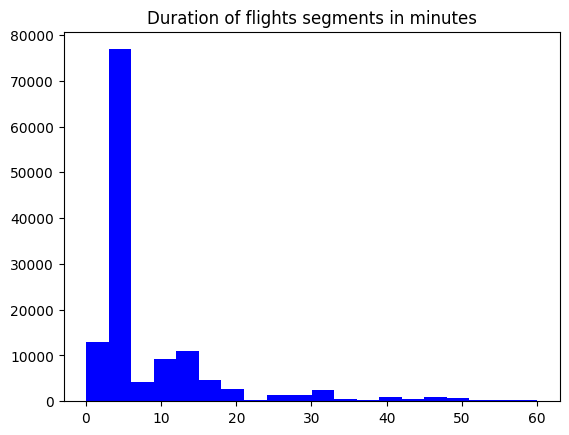

In [9]:
start = df.select("start")
end = df.select("end")

dur_minutes = (
    (df["end"] - df["start"])       # Duration dtype
      .dt.cast_time_unit("ms")           # pick a concrete unit
      .cast(pl.Float64) / 60_000.0    # ms -> minutes
)
print(dur_minutes.min())
print(dur_minutes.max())

list_duration = dur_minutes.to_list()

fig, ax = plt.subplots()

ax.hist(list_duration, 20, fill=True, color="blue")
ax.set_title('Duration of flights segments in minutes')

plt.show()

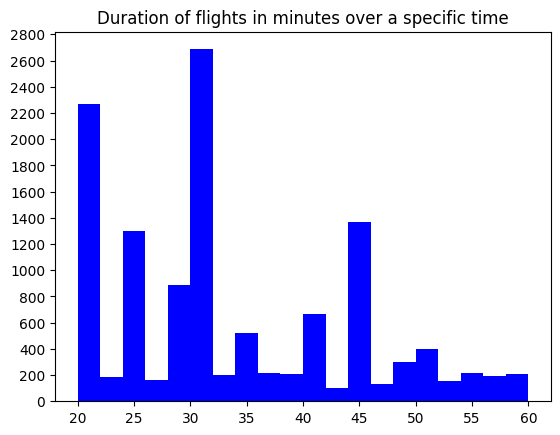

In [10]:
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

high_duration = []

for dur in list_duration:
    if dur > 20:
        high_duration.append(dur)

fig, ax = plt.subplots()

ax.hist(high_duration, 20, fill=True, color="blue")
ax.set_title('Duration of flights in minutes over a specific time')
ax.yaxis.set_major_locator(MultipleLocator(200))
plt.show()

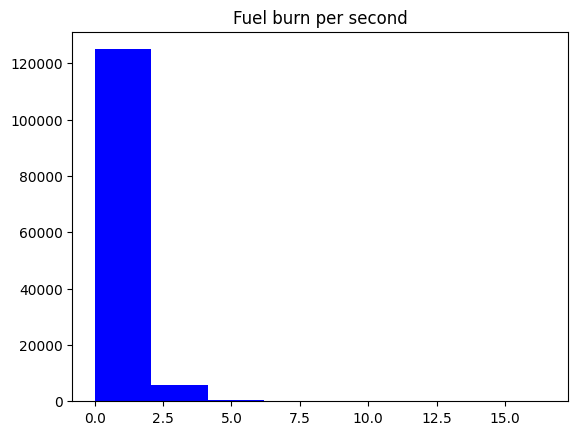

In [11]:
# fuel consumption per second

dur_seconds = (
    (df["end"] - df["start"])     # Duration
      .dt.cast_time_unit("ms")    # -> milliseconds
      .cast(pl.Float64) / 1_000.0 # -> seconds
)

fuel_consumption = df["fuel_kg"]

fuel_per_sec = fuel_consumption.to_numpy()
duration_per_sec = dur_seconds.to_numpy()

fuel_sec = fuel_per_sec/duration_per_sec

fig, ax = plt.subplots()

ax.hist(fuel_sec, 8, fill=True, color="blue")
ax.set_title('Fuel burn per second')

plt.show()



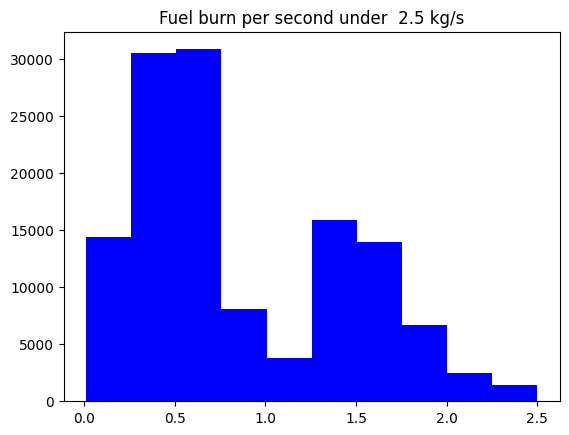

In [12]:
# fuel burn under 5 kg per second
low_fuel = []
limit = 2.5
for fuel in fuel_sec:
    if fuel < limit:
        low_fuel.append(fuel)


fig, ax = plt.subplots()

ax.hist(low_fuel, bins=10, fill=True, color="blue")
ax.set_title(f'Fuel burn per second under  {limit} kg/s')

plt.show()

Bin counts: [1130, 719, 488, 269, 137, 164, 98, 100, 53, 33]
Bin edges: [2.500016666777779, 2.849922014512767, 3.1998273622477553, 3.5497327099827434, 3.8996380577177314, 4.2495434054527195, 4.599448753187708, 4.949354100922696, 5.2992594486576845, 5.649164796392672, 5.999070144127661]


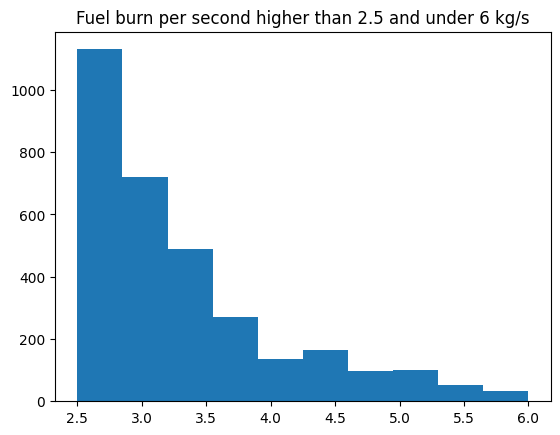

In [13]:
# fuel burn higher a limit kg per second
mid_fuel = []
l_limit = 2.5
h_limit = 6

for fuel in fuel_sec:
    if l_limit < fuel < h_limit:
        mid_fuel.append(fuel)


fig, ax = plt.subplots()

# ax.hist(high_fuel, 8, fill=True, color="blue")
ax.set_title(f'Fuel burn per second higher than {l_limit} and under {h_limit} kg/s')
n, bins, patches = plt.hist(mid_fuel)  # vals = your filtered list/array
print("Bin counts:", n.astype(int).tolist())
print("Bin edges:", bins.tolist())

plt.show()

Bin counts: [86, 54, 26, 15, 5, 9, 7, 6, 2, 1]
Bin edges: [6.00176774760375, 7.050711002395605, 8.099654257187462, 9.148597511979318, 10.197540766771173, 11.246484021563028, 12.295427276354886, 13.34437053114674, 14.393313785938595, 15.442257040730453, 16.491200295522308]


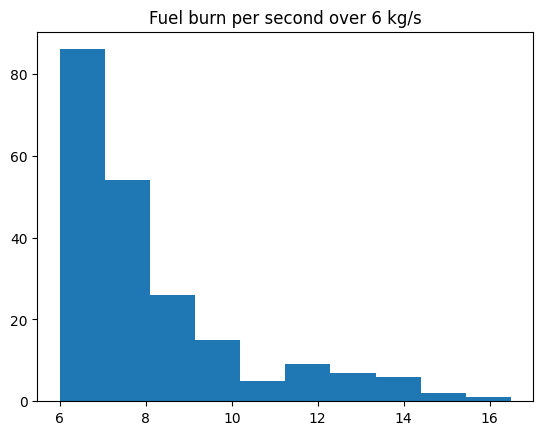

In [14]:
# fuel burn higher a limit kg per second
high_fuel = []
limit = 6
for fuel in fuel_sec:
    if fuel > limit:
        high_fuel.append(fuel)

fig, ax = plt.subplots()

# ax.hist(high_fuel, 8, fill=True, color="blue")
ax.set_title(f'Fuel burn per second over {limit} kg/s')
n, bins, patches = plt.hist(high_fuel)  # vals = your filtered list/array
print("Bin counts:", n.astype(int).tolist())
print("Bin edges:", bins.tolist())

plt.show()